# **Loading the dataset**

In [ ]:
import pandas as pd

# Load the dataset
file_path = "/content/train.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
print("Dataset Info:")
df.info()

# Show first few rows
print("\nFirst few rows of the dataset:")
print(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.3+ KB

First few rows of the dataset:
           id                                            premise  \
0  5130fd2cb5  and these comments were considered in formulat...   
1  5b72532a0b  These are issues that we wrestle with in pract...   
2  3931fbe82a  Des petites choses comme celles-là font une di...   
3  5622f0c60b  you know they can't really defend themselves l...   
4  86aaa48b45  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...   

                                          hypothesis lang_abv lan

# **Data Overview**

Total unique words in dataset: 68219

Sentence Length Statistics:
       premise_length  hypothesis_length
count    12120.000000       12120.000000
mean        17.990182           9.195297
std         12.898411           4.650281
min          1.000000           1.000000
25%          9.000000           6.000000
50%         16.000000           9.000000
75%         25.000000          12.000000
max        196.000000          46.000000


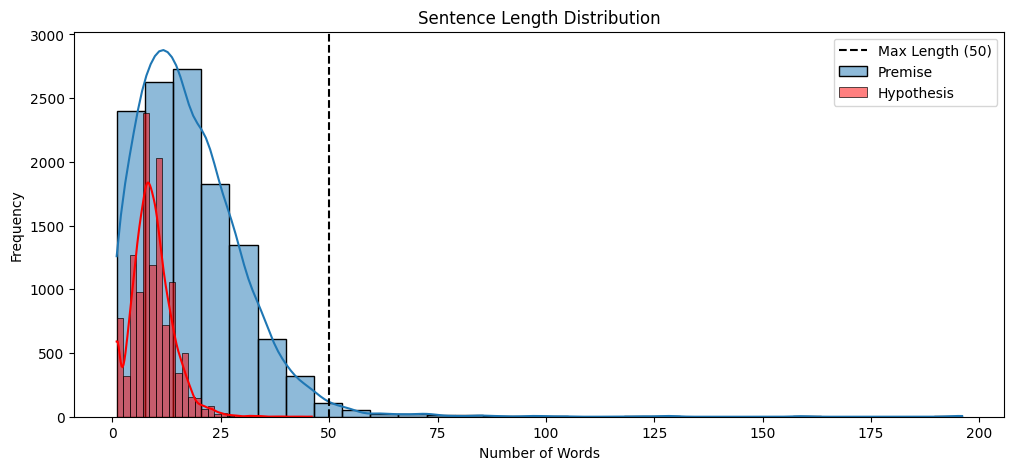

In [ ]:
# Check vocabulary size
from collections import Counter

# Combine all words from both premise and hypothesis
all_words = " ".join(df["premise"].tolist() + df["hypothesis"].tolist()).split()
unique_words = set(all_words)
print(f"Total unique words in dataset: {len(unique_words)}")

# Check sentence length distribution
df["premise_length"] = df["premise"].apply(lambda x: len(x.split()))
df["hypothesis_length"] = df["hypothesis"].apply(lambda x: len(x.split()))

print("\nSentence Length Statistics:")
print(df[["premise_length", "hypothesis_length"]].describe())

import matplotlib.pyplot as plt
import seaborn as sns

# Plot sentence length distributions
plt.figure(figsize=(12, 5))
sns.histplot(df["premise_length"], bins=30, kde=True, label="Premise")
sns.histplot(df["hypothesis_length"], bins=30, kde=True, color='red', label="Hypothesis")
plt.axvline(50, color='black', linestyle='--', label="Max Length (50)")
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# **Tokenization and Padding**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Set parameters based on analysis
MAX_VOCAB = 20000
MAX_LENGTH = 50

# Create and fit tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df["premise"].tolist() + df["hypothesis"].tolist())

# Convert text to sequences
premise_seq = tokenizer.texts_to_sequences(df["premise"])
hypothesis_seq = tokenizer.texts_to_sequences(df["hypothesis"])

# Pad sequences to ensure uniform length
premise_pad = pad_sequences(premise_seq, maxlen=MAX_LENGTH, padding="post", truncating="post")
hypothesis_pad = pad_sequences(hypothesis_seq, maxlen=MAX_LENGTH, padding="post", truncating="post")

# Convert labels to categorical (one-hot encoding)
y = to_categorical(df["label"], num_classes=3)

# Train-validation split (80-20)
train_premise, val_premise, train_hypothesis, val_hypothesis, train_y, val_y = train_test_split(
    premise_pad, hypothesis_pad, y, test_size=0.2, random_state=42, stratify=y
)

# Print shapes to verify
print("Train Premise Shape:", train_premise.shape)
print("Train Hypothesis Shape:", train_hypothesis.shape)
print("Train Labels Shape:", train_y.shape)
print("Validation Premise Shape:", val_premise.shape)
print("Validation Hypothesis Shape:", val_hypothesis.shape)
print("Validation Labels Shape:", val_y.shape)


Train Premise Shape: (9696, 50)
Train Hypothesis Shape: (9696, 50)
Train Labels Shape: (9696, 3)
Validation Premise Shape: (2424, 50)
Validation Hypothesis Shape: (2424, 50)
Validation Labels Shape: (2424, 3)


# **Bi-LSTM using Tuned Parameters**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

# Model parameters
EMBEDDING_DIM = 300  # Size of word embeddings
LSTM_UNITS = 128  # Number of LSTM units
DROPOUT_RATE = 0.5  # Regularization
NUM_CLASSES = 3  # Contradiction, Neutral, Entailment

# Input layers for premise and hypothesis
premise_input = Input(shape=(MAX_LENGTH,), name="premise_input")
hypothesis_input = Input(shape=(MAX_LENGTH,), name="hypothesis_input")

# Shared embedding layer
embedding_layer = Embedding(input_dim=MAX_VOCAB, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH, mask_zero=True)

# Apply embedding to both inputs
premise_embedding = embedding_layer(premise_input)
hypothesis_embedding = embedding_layer(hypothesis_input)

# Shared BiLSTM layer
bilstm_layer = Bidirectional(LSTM(LSTM_UNITS, return_sequences=False, dropout=DROPOUT_RATE))

# Process premise and hypothesis
premise_encoded = bilstm_layer(premise_embedding)
hypothesis_encoded = bilstm_layer(hypothesis_embedding)

# Merge the two representations
merged = Concatenate()([premise_encoded, hypothesis_encoded])

# Fully connected layers
dense1 = Dense(256, activation="relu")(merged)
drop1 = Dropout(DROPOUT_RATE)(dense1)
dense2 = Dense(128, activation="relu")(drop1)
drop2 = Dropout(DROPOUT_RATE / 2)(dense2)

# Output layer
output = Dense(NUM_CLASSES, activation="softmax", name="output")(drop2)

# Define and compile the model
model = Model(inputs=[premise_input, hypothesis_input], outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ premise_input             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hypothesis_input          │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 300)        │      6,000,000 │ premise_input[0][0],   │
│                           │                        │                │ hypothesis_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 50)             │              0 │ premise_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 50)             │              0 │ hypothesis_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 256)            │        439,296 │ embedding[0][0],       │
│ (Bidirectional)           │                        │                │ not_equal[0][0],       │
│                           │                        │                │ embedding[1][0],       │
│                           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512)            │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        131,328 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 3)              │            387 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,603,907 (25.19 MB)

 Trainable params: 6,603,907 (25.19 MB)

 Non-trainable params: 0 (0.00 B)

# **Model Training**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set training parameters
BATCH_SIZE = 64
EPOCHS = 20

# Callbacks
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
)
model_checkpoint = ModelCheckpoint(
    "best_bilstm_model.h5", save_best_only=True, monitor="val_accuracy", verbose=1
)

# Train the model
history = model.fit(
    [train_premise, train_hypothesis],
    train_y,
    validation_data=([val_premise, val_hypothesis], val_y),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1,
)

# Save training history
import pickle
with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Print final model evaluation
final_loss, final_acc = model.evaluate([val_premise, val_hypothesis], val_y, verbose=1)
print(f"Final Validation Accuracy: {final_acc:.4f}")
print(f"Final Validation Loss: {final_loss:.4f}")


Epoch 1/20
150/152 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3535 - loss: 1.0959
Epoch 1: val_accuracy improved from -inf to 0.40965, saving model to best_bilstm_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.3538 - loss: 1.0958 - val_accuracy: 0.4097 - val_loss: 1.0708
Epoch 2/20
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5183 - loss: 0.9750
Epoch 2: val_accuracy improved from 0.40965 to 0.44018, saving model to best_bilstm_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5183 - loss: 0.9749 - val_accuracy: 0.4402 - val_loss: 1.0788
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7284 - loss: 0.6626
Epoch 3: val_accuracy did not improve from 0.44018
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7283 - loss: 0.6627 - val_accuracy: 0.3808 - val_loss: 1.3653
Epoch 4/20
151/152 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8477 - loss: 0.3754
Epoch 4: val_accuracy did not improve from 0.44018
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8475 - loss: 0.3758 - val_accuracy: 0.3866 - val_loss: 1.7728
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3980 - loss: 1.0718
Final Validation Accuracy: 0.4105
Final Validation Loss: 1.0726


# **Model Evaluation**

76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step
Classification Report:
                precision    recall  f1-score   support

Contradiction       0.41      0.57      0.47       835
      Neutral       0.41      0.30      0.35       776
   Entailment       0.52      0.44      0.48       813

     accuracy                           0.44      2424
    macro avg       0.45      0.44      0.43      2424
 weighted avg       0.45      0.44      0.43      2424



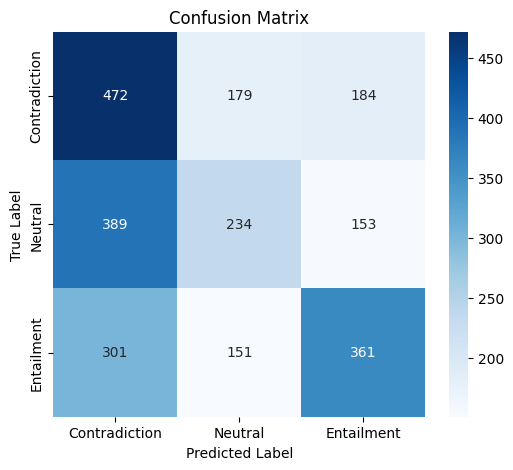

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load best model
model.load_weights("best_bilstm_model.h5")

# Make predictions
y_pred_probs = model.predict([val_premise, val_hypothesis])  # Get probability outputs
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true = np.argmax(val_y, axis=1)  # Convert one-hot labels to class labels

# Classification report (Precision, Recall, F1-score)
report = classification_report(y_true, y_pred, target_names=["Contradiction", "Neutral", "Entailment"])
print("Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Contradiction", "Neutral", "Entailment"], yticklabels=["Contradiction", "Neutral", "Entailment"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


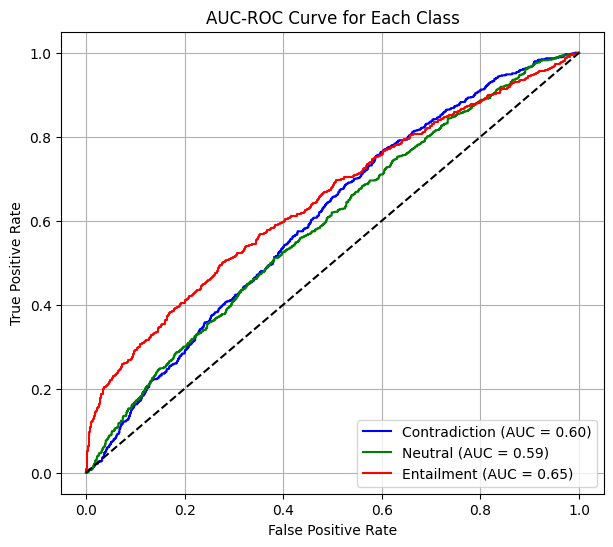

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class AUC-ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
y_pred_probs = np.array(y_pred_probs)  # Ensure it's a NumPy array

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):  # For each class (0 = Contradiction, 1 = Neutral, 2 = Entailment)
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot AUC-ROC curves
plt.figure(figsize=(7, 6))
plt.plot(fpr[0], tpr[0], label="Contradiction (AUC = {:.2f})".format(roc_auc[0]), color="blue")
plt.plot(fpr[1], tpr[1], label="Neutral (AUC = {:.2f})".format(roc_auc[1]), color="green")
plt.plot(fpr[2], tpr[2], label="Entailment (AUC = {:.2f})".format(roc_auc[2]), color="red")

plt.plot([0, 1], [0, 1], "k--")  # Random chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.grid()
plt.show()


Now will try the Custom ANN

### **Loading and Tokenizer**

In [ ]:
# Re-split the dataset
from sklearn.model_selection import train_test_split

# Load full dataset
df = pd.read_csv("/content/train.csv")

# Preprocess text (if needed)
df["premise"] = df["premise"].astype(str).str.lower().str.strip()
df["hypothesis"] = df["hypothesis"].astype(str).str.lower().str.strip()

# Convert labels to categorical
from tensorflow.keras.utils import to_categorical
y = to_categorical(df["label"], num_classes=3)

# Train-validation split
train_df, val_df, train_y, val_y = train_test_split(df, y, test_size=0.2, random_state=42, stratify=df["label"])

# Tokenization (assuming tokenizer was created earlier)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize premise & hypothesis
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(list(train_df["premise"]) + list(train_df["hypothesis"]))

train_premise = pad_sequences(tokenizer.texts_to_sequences(train_df["premise"]), maxlen=50, padding="post")
train_hypothesis = pad_sequences(tokenizer.texts_to_sequences(train_df["hypothesis"]), maxlen=50, padding="post")

val_premise = pad_sequences(tokenizer.texts_to_sequences(val_df["premise"]), maxlen=50, padding="post")
val_hypothesis = pad_sequences(tokenizer.texts_to_sequences(val_df["hypothesis"]), maxlen=50, padding="post")

# Convert language column to one-hot encoding
train_lang_features = pd.get_dummies(train_df["language"], prefix="lang").values
val_lang_features = pd.get_dummies(val_df["language"], prefix="lang").values

# Check feature shapes
print(f"Train Premise Shape: {train_premise.shape}")
print(f"Train Hypothesis Shape: {train_hypothesis.shape}")
print(f"Train Labels Shape: {train_y.shape}")
print(f"Train Language Features Shape: {train_lang_features.shape}")

print(f"Validation Premise Shape: {val_premise.shape}")
print(f"Validation Hypothesis Shape: {val_hypothesis.shape}")
print(f"Validation Labels Shape: {val_y.shape}")
print(f"Validation Language Features Shape: {val_lang_features.shape}")


Train Premise Shape: (9696, 50)
Train Hypothesis Shape: (9696, 50)
Train Labels Shape: (9696, 3)
Train Language Features Shape: (9696, 15)
Validation Premise Shape: (2424, 50)
Validation Hypothesis Shape: (2424, 50)
Validation Labels Shape: (2424, 3)
Validation Language Features Shape: (2424, 15)


# **Model Architecture**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
import pandas as pd

# Extract language features (one-hot encoding)
language_features = pd.get_dummies(df["language"], prefix="lang").values
num_languages = language_features.shape[1]

# Model parameters
DENSE_UNITS = 256  # Wider layers instead of deep stacking
DROPOUT_RATE = 0.4  # Higher dropout for regularization
NUM_CLASSES = 3

# Input layers
premise_input = Input(shape=(MAX_LENGTH,), name="premise_input")
hypothesis_input = Input(shape=(MAX_LENGTH,), name="hypothesis_input")
language_input = Input(shape=(num_languages,), name="language_input")  # One-hot encoded language

# Fully connected layers
merged = Concatenate()([premise_input, hypothesis_input, language_input])

dense1 = Dense(DENSE_UNITS, activation="relu")(merged)
batch_norm1 = BatchNormalization()(dense1)
drop1 = Dropout(DROPOUT_RATE)(batch_norm1)

dense2 = Dense(DENSE_UNITS//2, activation="relu")(drop1)
batch_norm2 = BatchNormalization()(dense2)
drop2 = Dropout(DROPOUT_RATE)(batch_norm2)

dense3 = Dense(DENSE_UNITS//4, activation="relu")(drop2)
batch_norm3 = BatchNormalization()(dense3)
drop3 = Dropout(DROPOUT_RATE)(batch_norm3)

# Output layer
output = Dense(NUM_CLASSES, activation="softmax", name="output")(drop3)

# Define and compile the model
model = Model(inputs=[premise_input, hypothesis_input, language_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss="categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ premise_input             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hypothesis_input          │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ language_input            │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 115)            │              0 │ premise_input[0][0],   │
│ (Concatenate)             │                        │                │ hypothesis_input[0][0… │
│                           │                        │                │ language_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 256)            │         29,696 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 256)            │          1,024 │ dense_11[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 256)            │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 128)            │         32,896 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 128)            │            512 │ dense_12[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 128)            │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 64)             │          8,256 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 64)             │            256 │ dense_13[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 64)             │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 3)              │            195 │ dropout_13[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 72,835 (284.51 KB)

 Trainable params: 71,939 (281.01 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
import pandas as pd

# Convert language column to one-hot encoding
train_lang_features = pd.get_dummies(train_df["language"], prefix="lang").values
val_lang_features = pd.get_dummies(val_df["language"], prefix="lang").values

# Ensure the feature dimensions match
print(f"Train Language Feature Shape: {train_lang_features.shape}")
print(f"Validation Language Feature Shape: {val_lang_features.shape}")


Train Language Feature Shape: (9696, 15)
Validation Language Feature Shape: (2424, 15)


# **Customized Model Training**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set training parameters
BATCH_SIZE = 64
EPOCHS = 20

# Callbacks
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
)
model_checkpoint = ModelCheckpoint(
    "best_custom_ann_model.h5", save_best_only=True, monitor="val_accuracy", verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1
)

# Train the model
history = model.fit(
    [train_premise, train_hypothesis, train_lang_features],  # Now includes language features
    train_y,
    validation_data=([val_premise, val_hypothesis, val_lang_features], val_y),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1,
)

# Save training history
import pickle
with open("training_history_custom_ann.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Print final evaluation
final_loss, final_acc = model.evaluate([val_premise, val_hypothesis, val_lang_features], val_y, verbose=1)
print(f"Final Validation Accuracy: {final_acc:.4f}")
print(f"Final Validation Loss: {final_loss:.4f}")


Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3326 - loss: 1.6608
Epoch 1: val_accuracy improved from -inf to 0.32261, saving model to best_custom_ann_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.3326 - loss: 1.6604 - val_accuracy: 0.3226 - val_loss: 1.1680 - learning_rate: 3.0000e-04
Epoch 2/20
146/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3346 - loss: 1.4876
Epoch 2: val_accuracy improved from 0.32261 to 0.33045, saving model to best_custom_ann_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3348 - loss: 1.4861 - val_accuracy: 0.3304 - val_loss: 1.1485 - learning_rate: 3.0000e-04
Epoch 3/20
137/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3347 - loss: 1.3678
Epoch 3: val_accuracy did not improve from 0.33045
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3353 - loss: 1.3664 - val_accuracy: 0.3280 - val_loss: 1.1351 - learning_rate: 3.0000e-04
Epoch 4/20
136/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3427 - loss: 1.3050
Epoch 4: val_accuracy did not improve from 0.33045
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3424 - loss: 1.3039 - val_accuracy: 0.3238 - val_loss: 1.1241 - learning_rate: 3.0000e-04
Epoch 5/20
140/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3488 - loss: 1.2501
Epoch 5: val_accuracy improved from 0.33045 to 0.33292, saving model to best_custom_ann_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3485 - loss: 1.2500 - val_accuracy: 0.3329 - val_loss: 1.1179 - learning_rate: 3.0000e-04
Epoch 6/20
138/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3519 - loss: 1.2178
Epoch 6: val_accuracy improved from 0.33292 to 0.33622, saving model to best_custom_ann_model.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3515 - loss: 1.2179 - val_accuracy: 0.3362 - val_loss: 1.1153 - learning_rate: 3.0000e-04
Epoch 7/20
140/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3411 - loss: 1.2083
Epoch 7: val_accuracy did not improve from 0.33622
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3416 - loss: 1.2070 - val_accuracy: 0.3288 - val_loss: 1.1114 - learning_rate: 3.0000e-04
Epoch 8/20
140/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3520 - loss: 1.1669
Epoch 8: val_accuracy did not improve from 0.33622
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3516 - loss: 1.1670 - val_accuracy: 0.3263 - val_loss: 1.1105 - learning_rate: 3.0000e-04
Epoch 9/20
135/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3478 - loss: 1.1626
Epoch 9: val_accuracy did not improve from 0.33622
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3480 - loss: 1.1614 - val_accuracy: 0.3309 - val_loss: 1.1089 - learning_rate: 3.0000e-04
Epoch 10/